In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
import utils

In [4]:
import goexplore_train
from goexplore_train import *

In [5]:
args = goexplore_train.parser.parse_args("--track=True --project=ge_train --name=ge_train_best_0000   --device=cuda --env_ids Amidar Assault Asterix Asteroids Atlantis BankHeist BattleZone BeamRider Berzerk Bowling Breakout Centipede ChopperCommand CrazyClimber Defender DemonAttack DoubleDunk Enduro FishingDerby Freeway Frostbite Gopher Gravitar Hero IceHockey Jamesbond Kangaroo Krull KungFuMaster MontezumaRevenge NameThisGame Phoenix Pitfall PrivateEye Qbert Riverraid RoadRunner Robotank Seaquest Solaris Surround Tennis TimePilot Tutankham UpNDown WizardOfWor YarsRevenge Zaxxon --strategy=best   --save_agent=./data/ge_train/ge_train_best_0000   --n_archives=40".split())




In [6]:
args.device = 'cuda:0'

In [7]:
print("Loading archives")
env_id2archives = load_env_id2archives(args.env_ids, args.n_archives)
print("Creating trajs")
env_id2trajs = get_env_id2trajs(env_id2archives, strategy=args.strategy)
for env_id, trajs in env_id2trajs.items():
    print(f"env_id: {env_id}, #trajs: {len(trajs)}")

print("Creating envs")
make_env_fns = []
for env_id in args.env_ids:
    make_env_fns.extend([partial(make_ge_env_single, env_id=env_id) for _ in range(args.n_envs)])
env = MyAsyncVectorEnv(make_env_fns)

def sample_traj_fn(id):
    env_id = args.env_ids[id // args.n_envs]
    trajs = env_id2trajs[env_id]
    return trajs[np.random.choice(len(trajs))]

print("Creating buffer")
buf = GEBuffer(env, args.n_steps, sample_traj_fn=sample_traj_fn, device=args.device)

Loading archives


  0%|          | 0/48 [00:00<?, ?it/s]

Creating trajs


  0%|          | 0/48 [00:00<?, ?it/s]

env_id: Amidar, #trajs: 40
env_id: Assault, #trajs: 40
env_id: Asterix, #trajs: 40
env_id: Asteroids, #trajs: 40
env_id: Atlantis, #trajs: 40
env_id: BankHeist, #trajs: 40
env_id: BattleZone, #trajs: 40
env_id: BeamRider, #trajs: 40
env_id: Berzerk, #trajs: 40
env_id: Bowling, #trajs: 40
env_id: Breakout, #trajs: 40
env_id: Centipede, #trajs: 40
env_id: ChopperCommand, #trajs: 40
env_id: CrazyClimber, #trajs: 40
env_id: Defender, #trajs: 40
env_id: DemonAttack, #trajs: 40
env_id: DoubleDunk, #trajs: 40
env_id: Enduro, #trajs: 40
env_id: FishingDerby, #trajs: 40
env_id: Freeway, #trajs: 40
env_id: Frostbite, #trajs: 40
env_id: Gopher, #trajs: 40
env_id: Gravitar, #trajs: 40
env_id: Hero, #trajs: 40
env_id: IceHockey, #trajs: 40
env_id: Jamesbond, #trajs: 40
env_id: Kangaroo, #trajs: 40
env_id: Krull, #trajs: 40
env_id: KungFuMaster, #trajs: 40
env_id: MontezumaRevenge, #trajs: 40
env_id: NameThisGame, #trajs: 40
env_id: Phoenix, #trajs: 40
env_id: Pitfall, #trajs: 40
env_id: PrivateEye,

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Creating buffer


In [9]:
print("Creating agent")
agent = utils.create_agent('gpt', 18, args.ctx_len, load_agent='./data/ge_train/ge_train_best_0000.pt', device=args.device)
# agent_rand = utils.create_agent('gpt', 18, 64, load_agent='./data/ge_train/ge_train_random_0000.pt', device=device)

Creating agent


In [10]:
args.n_iters = 10

In [11]:
losses = []

In [12]:
print("Starting learning")
pbar_iters = tqdm(total=args.n_iters)
pbar_steps = tqdm(total=args.n_steps)
pbar_updates = tqdm(total=args.n_updates)
for i_iter in range(args.n_iters):
    pbar_iters.update(1)

    pbar_steps.reset(total=args.n_steps)
    buf.gecollect(pbar=pbar_steps)

    pbar_updates.reset(total=args.n_updates)
    for i_update in range(args.n_updates):
        pbar_updates.update(1)
        assert args.batch_size % (len(args.env_ids) * args.n_envs) == 0
        batch = buf.generate_batch(args.batch_size, args.ctx_len)
        obs, act = batch["obs"], batch["act"]
        obs = obs[:, :, None, :, :]
        logits, values = agent(None, obs, act, None)

        loss_bc = torch.nn.functional.cross_entropy(rearrange(logits, "b t d -> (b t) d"), rearrange(act, "b t -> (b t)"), reduction="none")
        loss_bc = rearrange(loss_bc, "(b t) -> b t", b=args.batch_size)
        losses.append(loss_bc.detach().cpu())

Starting learning


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [14]:
losses = torch.cat(losses, dim=0)

Text(0.5, 1.0, 'PPL vs ctx len')

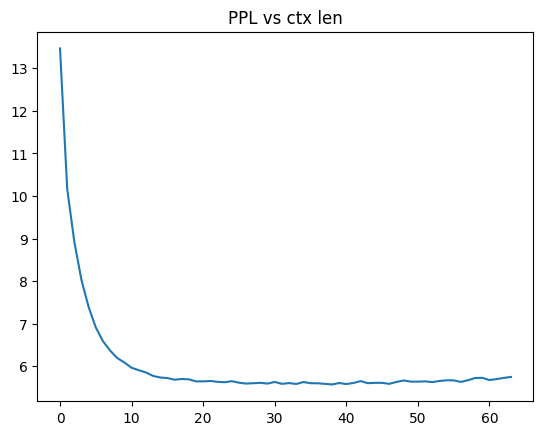

In [16]:
plt.plot(losses.mean(dim=0).exp().numpy())
plt.title('PPL vs ctx len')

In [20]:
np.e**(losses.mean().item())

5.944918757005274